# lasagne
* lasagne - это библиотека для написания нейронок произвольной формы на theano
* библиотека низкоуровневая, границы между theano и lasagne практически нет

В качестве демо-задачи выберем то же распознавание чисел, но на большем масштабе задачи
* картинки 28x28
* 10 цифр

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print X_train.shape, y_train.shape

(50000, 1, 28, 28) (50000,)


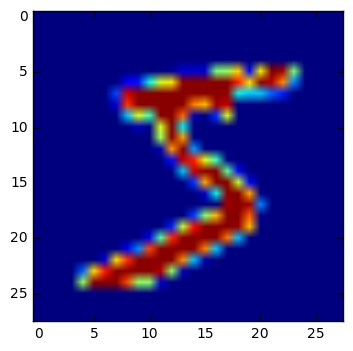

In [10]:
plt.imshow(X_train[0,0])

In [11]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

Так задаётся архитектура нейронки

In [12]:
#входной слой (вспомогательный)
input_layer = lasagne.layers.InputLayer(shape=(None,1,28,28), input_var=input_X)

#полносвязный слой, который принимает на вход input layer и имеет 100 нейронов.
# нелинейная функция - сигмоида как в логистической регрессии
# слоям тоже можно давать имена, но это необязательно
dense_1 = lasagne.layers.DenseLayer(input_layer,num_units=50, nonlinearity=sigmoid, name="hidden_dense_layer")

#ВЫХОДНОЙ полносвязный слой, который принимает на вход dense_1 и имеет 10 нейронов -по нейрону на цифру
#нелинейность - softmax - чтобы вероятности всех цифр давали в сумме 1
dense_output = lasagne.layers.DenseLayer(dense_1,num_units = 10, nonlinearity=softmax)

In [13]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

In [14]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print all_weights

[hidden_dense_layer.W, hidden_dense_layer.b, W, b]


### дальше вы могли бы просто
* задать функцию ошибки вручную
* посчитать градиент ошибки по all_weights
* написать updates
* но это долго, а простой шаг по градиенту - не самый лучший смособ оптимизировать веса

Вместо этого, опять используем lasagne

In [15]:
#функция ошибки - средняя кроссэнтропия
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
updates_sgd = lasagne.updates.rmsprop(loss, all_weights,learning_rate=0.01)

In [16]:
#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#функция, которая считает точность
accuracy_fun = theano.function([input_X,target_y],accuracy)

### Вот и всё, пошли её учить
* данных теперь много, поэтому лучше учиться стохастическим градиентным спуском
* для этого напишем функцию, которая бьёт выпорку на мини-батчи (в обычном питоне, не в theano)

In [17]:
# вспомогательная функция, которая возвращает список мини-батчей для обучения нейронки

#на вход
# inputs - тензор из картинок размером (много, 1, 28, 28), например - X_train
# targets - вектор из чиселок - ответов для каждой картинки из X; например - Y_train
# batchsize - одно число - желаемый размер группы

#что нужно сделать
# 1) перемешать данные
# - важно перемешать targets и targets одним и тем же образом, чтобы сохранить соответствие картинки ответу на неё
# 3) побить данные на подгруппы так, чтобы в каждой подгруппе было batchsize картинок и ответов
# - если число картинок не делится на batchsize, одну подгруппу можно вернуть другого размера
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [18]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 10 took 1.207s
  training loss (in-iteration):		0.285811
  train accuracy:		91.78 %
  validation accuracy:		95.11 %
Epoch 2 of 10 took 0.868s
  training loss (in-iteration):		0.149138
  train accuracy:		95.69 %
  validation accuracy:		95.46 %
Epoch 3 of 10 took 0.951s
  training loss (in-iteration):		0.113987
  train accuracy:		96.65 %
  validation accuracy:		95.82 %
Epoch 4 of 10 took 1.010s
  training loss (in-iteration):		0.095110
  train accuracy:		97.22 %
  validation accuracy:		95.93 %
Epoch 5 of 10 took 0.963s
  training loss (in-iteration):		0.079750
  train accuracy:		97.68 %
  validation accuracy:		95.99 %
Epoch 6 of 10 took 1.068s
  training loss (in-iteration):		0.068710
  train accuracy:		98.00 %
  validation accuracy:		96.13 %
Epoch 7 of 10 took 1.072s
  training loss (in-iteration):		0.060880
  train accuracy:		98.27 %
  validation accuracy:		96.28 %
Epoch 8 of 10 took 0.939s
  training loss (in-iteration):		0.054298
  train accuracy:		98.50 %
  validation acc

In [19]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		96.00 %
Нужно больше магии!


# Нейронка твоей мечты


* Задача - сделать нейронку, которая получит точность 99% на валидации (validation accuracy)
 * Вариант "is fine too" - 97.5%. 
 * Чем выше, тем лучше.
 
__ В конце есть мини-отчётик, который имеет смысл прочитать вначале и заполнять по ходу работы. __
 

## Что можно улучшить:



 * размер сети
   * бОльше нейронов, 
   * бОльше слоёв, 
   
 * регуляризация - чтобы не переобучалось
   * приплюсовать к функции ошибки какую-нибудь сумму квадратов весов
   * можно сделать вручную, а можно - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - для борьбы с переобучением
       * `lasagne.layers.DropoutLayer(предыдущий_слой, p=вероятность_занулить)`
   
 * Метод оптимизации - adam, rmsprop, nesterov_momentum, adadelta, adagrad и т.п.
   * сходятся быстрее и иногда - к лучшему оптимуму
   * имеет смысл поиграть с размером батча, количеством эпох и скоростью обучения
   
 * Наконец, можно поиграть с нелинейностями в скрытых слоях
   * tanh, relu, leaky relu, etc

In [20]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print X_train.shape,y_train.shape

(50000, 1, 28, 28) (50000,)


In [139]:
import lasagne

input_X = T.tensor4("X")

#размерность входа (None означает "может изменяться")
input_shape = (None,1,28,28)

target_y = T.vector("target Y integer",dtype='int32')

In [140]:
#входной слой (вспомогательный)
input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

drop_input = lasagne.layers.DropoutLayer(input_layer, p = 0.2)
dense_1 = lasagne.layers.DenseLayer(drop_input, num_units = 1000, nonlinearity = leaky_rectify)
drop_1 = lasagne.layers.DropoutLayer(dense_1, p = 0.5)
dense_2 = lasagne.layers.DenseLayer(drop_1, num_units = 500, nonlinearity = leaky_rectify)
drop_2 = lasagne.layers.DropoutLayer(dense_2, p = 0.5)
#dense_3 = lasagne.layers.DenseLayer(drop_2, num_units = 250, nonlinearity = leaky_rectify)
#drop_3 = lasagne.layers.DropoutLayer(dense_3, p = 0.5)
#dense_4 = lasagne.layers.DenseLayer(drop_3, num_units = 75, nonlinearity = leaky_rectify)
#drop_4 = lasagne.layers.DropoutLayer(dense_4, p = 0.8)
#ВЫХОДНОЙ полносвязный слой, который принимает на вход dense_1 и имеет 10 нейронов -по нейрону на цифру
#нелинейность - softmax - чтобы вероятности всех цифр давали в сумме 1
dense_output = lasagne.layers.DenseLayer(drop_2,num_units = 10,
                                        nonlinearity = lasagne.nonlinearities.softmax,
                                        name='output')


In [141]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output, deterministic=False)
y_predicted_test = lasagne.layers.get_output(dense_output, deterministic=True)

In [142]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print all_weights

[W, b, W, b, output.W, output.b]
[W, W, output.W]


In [143]:
#функция ошибки - средняя кроссэнтропия
max_norm = 1000
#penalty = lasagne.regularization.regularize_network_params(dense_output, lasagne.regularization.l2)*0.000001
#penalty = T.largest(lasagne.regularization.regularize_network_params(dense_output, lasagne.regularization.l2),max_norm) - max_norm
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean() #+ penalty

#<возможно добавить регуляризатор>

accuracy = lasagne.objectives.categorical_accuracy(y_predicted_test,target_y).mean()

#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
updates_sgd = lasagne.updates.adadelta(loss, all_weights,learning_rate=1)

In [144]:
#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X,target_y], [loss,accuracy], updates = updates_sgd)
norm_constrain_fun = theano.function([], [], updates = zip(all_weights,lasagne.updates.total_norm_constraint(all_weights, 10000)))

#функция, которая считает точность
accuracy_fun = theano.function([input_X,target_y],accuracy)
predict = theano.function([input_X], y_predicted_test)

In [145]:
epoch_number = 0

In [162]:
#итерации обучения
num_epochs = 5 #количество проходов по данным

batch_size = 200 #размер мини-батча

for epoch in range(num_epochs):
    epoch_number +=1
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size, shuffle = True):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        #norm_constrain_fun()
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch_number, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 31 of 5 took 39.794s
  training loss (in-iteration):		0.046465
  train accuracy:		99.74 %
  validation accuracy:		98.39 %
Epoch 32 of 5 took 85.742s
  training loss (in-iteration):		0.045244
  train accuracy:		99.75 %
  validation accuracy:		98.49 %
Epoch 33 of 5 took 89.691s
  training loss (in-iteration):		0.045691
  train accuracy:		99.77 %
  validation accuracy:		98.58 %
Epoch 34 of 5 took 92.215s
  training loss (in-iteration):		0.045622
  train accuracy:		99.78 %
  validation accuracy:		98.50 %
Epoch 35 of 5 took 96.337s
  training loss (in-iteration):		0.046517
  train accuracy:		99.77 %
  validation accuracy:		98.49 %


In [164]:
all_weights[3].get_value().max()

0.16584271491002134

In [165]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

Final results:
  test accuracy:		98.53 %


### ПРИМЕРЫ ФЕЙЛОВ


digit 5 predict 6 [  6.52037842e-12   9.73680712e-11   5.23312898e-11   2.19325087e-12
   8.88648543e-09   3.13926017e-01   6.86070540e-01   1.77635055e-13
   3.19224050e-06   2.41650906e-07]


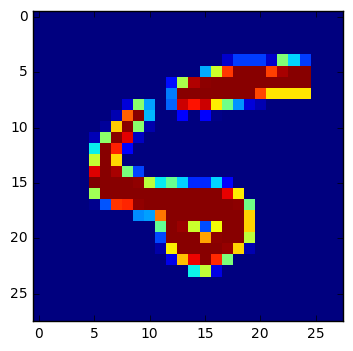

digit 4 predict 2 [  3.27833669e-07   1.01108673e-06   9.07177921e-01   6.19479598e-08
   6.88273616e-02   4.51148593e-07   2.39928507e-02   7.00239602e-09
   6.80175331e-09   1.03598872e-09]


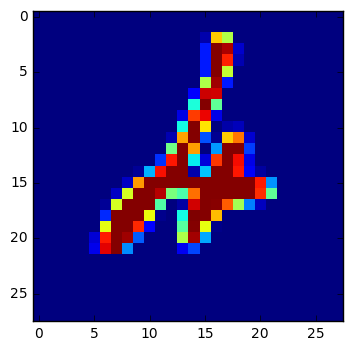

digit 2 predict 7 [  4.40328391e-08   1.91953230e-05   4.55165307e-01   5.61059385e-03
   1.03921977e-11   1.12309830e-08   5.28167682e-11   5.38869589e-01
   3.35248973e-04   1.04391188e-08]


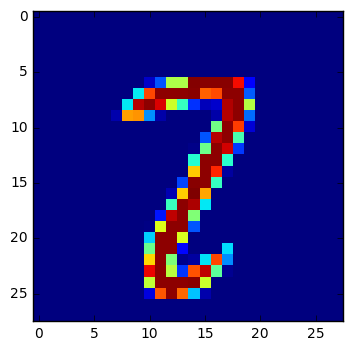

digit 6 predict 0 [  9.99892054e-01   5.93544637e-14   5.80831756e-13   4.50688878e-12
   1.37324998e-12   1.70726805e-06   1.06000352e-04   2.38680682e-07
   4.16636794e-12   1.03764922e-11]


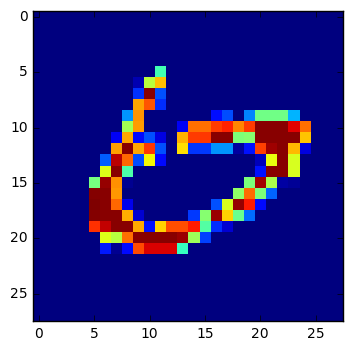

digit 4 predict 9 [  1.00174909e-04   1.42757570e-03   4.03161663e-05   2.95847554e-05
   2.90603990e-01   3.08811597e-05   8.09403470e-07   2.60549817e-03
   1.16793024e-04   7.05044377e-01]


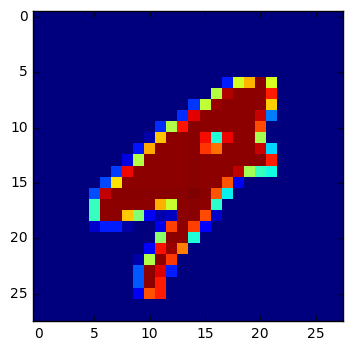

digit 3 predict 5 [  8.95077056e-13   7.09747702e-09   1.60806287e-11   3.61298687e-01
   2.79995279e-12   6.38701136e-01   3.25873707e-10   4.55851106e-12
   1.30147651e-09   1.68231350e-07]


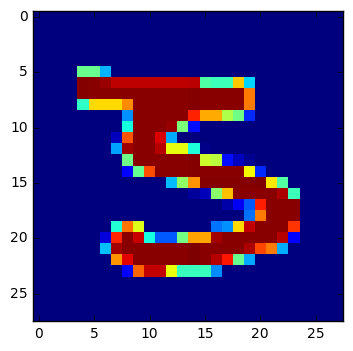

digit 8 predict 2 [  2.95650508e-09   4.59223180e-03   9.85470607e-01   3.40499682e-03
   1.91956750e-09   4.60465476e-10   1.54493537e-09   3.68374417e-06
   6.52847342e-03   3.91541596e-11]


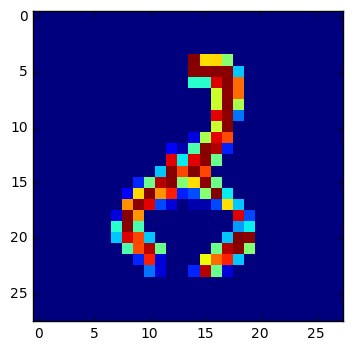

digit 2 predict 6 [  5.51556425e-06   2.27378409e-04   1.53653634e-01   2.94148928e-07
   3.01159873e-03   2.17142550e-06   8.43099354e-01   2.04794158e-08
   3.26372611e-08   7.47581189e-11]


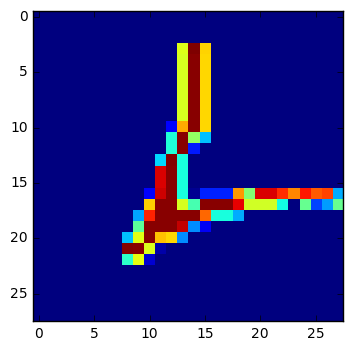

digit 7 predict 3 [  1.76068568e-05   8.90035983e-03   2.44081667e-02   6.07712630e-01
   1.35413414e-03   4.25743537e-04   1.28389311e-06   3.07149946e-01
   1.92292398e-04   4.98378362e-02]


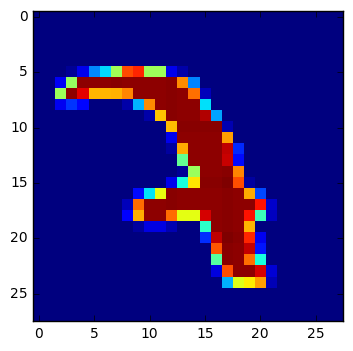

digit 8 predict 4 [  2.73516939e-05   4.20316504e-04   7.30678201e-05   2.08697074e-04
   5.97583477e-01   7.77672462e-04   4.02072273e-04   1.92603364e-03
   3.58888435e-01   3.96928767e-02]


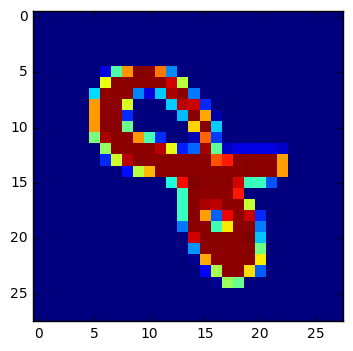

digit 5 predict 8 [  2.35876284e-09   1.34780176e-09   4.36162801e-07   3.69679935e-07
   6.51599258e-10   6.01933538e-05   2.20434753e-07   6.06514152e-11
   9.99938776e-01   1.41112831e-10]


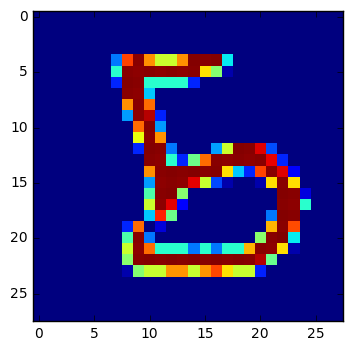

digit 4 predict 9 [  1.00776631e-07   3.04960296e-05   1.00415662e-07   7.27420568e-08
   7.05268699e-02   2.99573869e-08   8.72997349e-10   3.91047530e-04
   2.11061393e-07   9.29051071e-01]


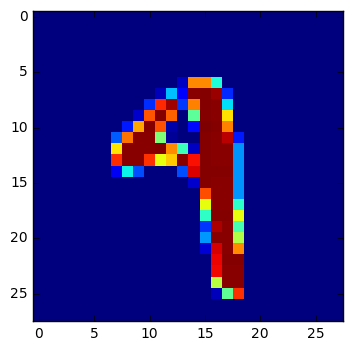

digit 8 predict 9 [  3.77045586e-03   3.03590000e-04   1.07345090e-03   5.78098829e-03
   2.23294980e-03   3.18927479e-04   4.14099855e-04   9.91182374e-04
   2.71909194e-01   7.13205161e-01]


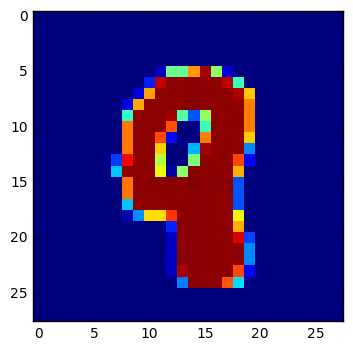

digit 6 predict 5 [  2.24164569e-04   1.50169764e-06   3.46544770e-06   6.43499586e-06
   2.91318884e-07   9.90218417e-01   6.09031773e-03   2.12798252e-06
   3.40813805e-03   4.51409110e-05]


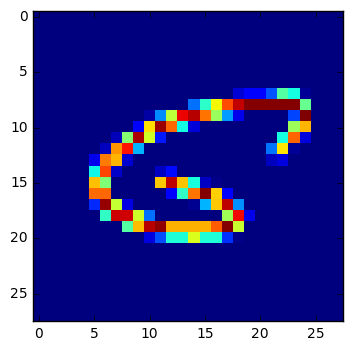

digit 7 predict 1 [  5.12007460e-04   5.24130254e-01   2.78308907e-01   6.12955119e-03
   2.91872197e-02   1.14798384e-02   1.20014740e-02   6.46896044e-02
   7.23684306e-02   1.19271258e-03]


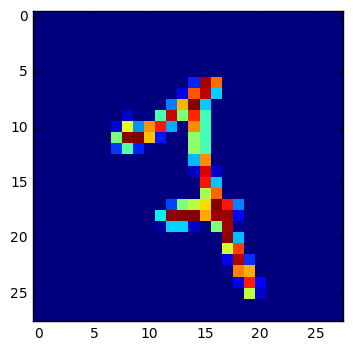

digit 6 predict 8 [  2.11838655e-02   9.74240619e-04   1.83717023e-02   1.82506627e-03
   4.74465004e-02   5.63119676e-03   3.06348579e-01   1.17771764e-04
   5.97945541e-01   1.55536459e-04]


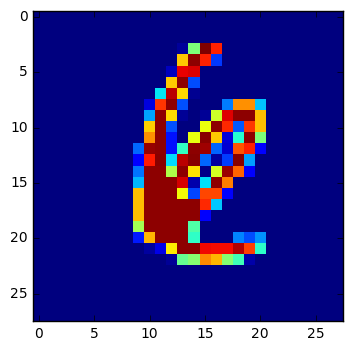

digit 4 predict 6 [  1.13753007e-06   9.70748787e-10   1.82299345e-06   1.11322099e-10
   1.63602448e-02   4.67537111e-09   9.83636789e-01   1.44353978e-11
   5.60613789e-12   5.92342948e-11]


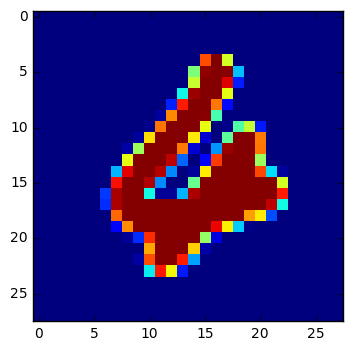

digit 7 predict 8 [  2.39378997e-04   7.79149321e-04   3.24951702e-04   7.58509576e-03
   1.93737640e-04   3.79807869e-02   9.07671486e-04   3.63315012e-03
   9.46893186e-01   1.46289246e-03]


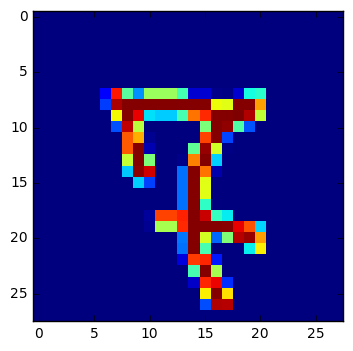

digit 6 predict 5 [  7.45517481e-07   4.74989627e-07   1.69971190e-07   1.08821624e-05
   5.74214121e-08   8.27110408e-01   1.58063952e-01   7.76920692e-09
   1.47406466e-02   7.26557248e-05]


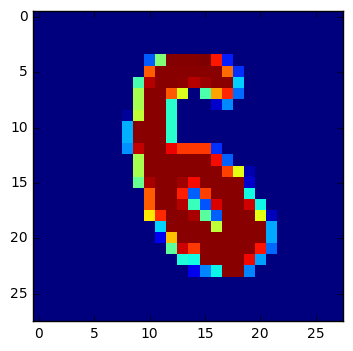

digit 7 predict 2 [  1.81079575e-09   3.59513871e-02   9.59695210e-01   2.12409772e-03
   1.55495718e-08   5.99429849e-07   1.09988854e-07   2.21465840e-03
   1.39166787e-05   3.34349278e-09]


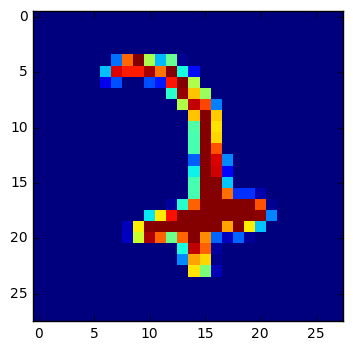

digit 9 predict 4 [  6.00208058e-03   9.51004440e-03   7.22904640e-04   7.32569208e-05
   9.14371540e-01   7.15906499e-04   3.95658248e-03   5.96352018e-04
   2.43372896e-03   6.16176037e-02]


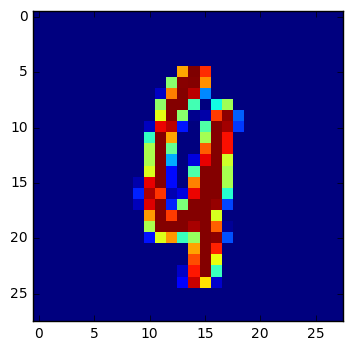

In [170]:
n = 0
for batch in iterate_minibatches(X_test, y_test, 1):
    inputs, targets = batch
    if  accuracy_fun(inputs, targets) < 1:
        n += 1
        print 'digit', targets[0], 'predict', np.argmax(predict(inputs)), predict(inputs)[0]
        plt.show(plt.imshow(inputs.reshape([28,28]), interpolation="nearest"))
    if n > 20:
        break